In [53]:
# TEST CELL - Run this first!
# Click here and press Shift+Enter
print("✓ Notebook is working!")
print("✓ Python is running!")
result = 2 + 2
print(f"✓ Math works: 2 + 2 = {result}")
print("\nIf you see this text, the notebook is configured correctly!")

✓ Notebook is working!
✓ Python is running!
✓ Math works: 2 + 2 = 4

If you see this text, the notebook is configured correctly!


## ⚠️ START HERE - Test Cell

Run this cell first to make sure your notebook is working!

## 1. Setup - Import Libraries

In [54]:
import json
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution
from scipy.interpolate import interp1d
import seaborn as sns

# Set plotting style - try to use seaborn style, fallback if not available
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Loading & Parsing

Parse the log file format:
```
2026/01/01-22:12:43 {"message": [{"currenttemp": 198, "internatemp": 63, "targettemp": 200, "servoangle": 105}]}
```

In [55]:
def parse_log_file(filepath):
    """
    Parse BBQ grill log file into a pandas DataFrame.
    
    Args:
        filepath: Path to the log file
        
    Returns:
        DataFrame with columns: timestamp, grill_temp, meat_temp, target_temp, servo_angle
    """
    data = []
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            # Extract timestamp and JSON
            match = re.match(r'(\d{4}/\d{2}/\d{2}-\s*\d{1,2}:\d{2}:\d{2})\s*({.*})', line)
            if not match:
                continue
                
            timestamp_str, json_str = match.groups()
            
            try:
                # Parse timestamp
                timestamp = datetime.strptime(timestamp_str, '%Y/%m/%d-%H:%M:%S')
                
                # Parse JSON (handle trailing comma)
                json_str = json_str.rstrip(',')
                json_data = json.loads(json_str)
                
                # Extract values
                if 'message' in json_data and len(json_data['message']) > 0:
                    msg = json_data['message'][0]
                    data.append({
                        'timestamp': timestamp,
                        'grill_temp': msg['currenttemp'],
                        'meat_temp': msg['internatemp'],
                        'target_temp': msg['targettemp'],
                        'servo_angle': msg['servoangle']
                    })
            except (json.JSONDecodeError, KeyError, ValueError) as e:
                print(f"Error parsing line: {line[:50]}... Error: {e}")
                continue
    
    df = pd.DataFrame(data)
    
    # Calculate time in seconds from start
    if len(df) > 0:
        df['time_seconds'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()
        df['time_minutes'] = df['time_seconds'] / 60
    
    return df

In [56]:
# Load the data - CSV file
log_file = r'C:\GitHub\HaBBQVisual\script\260102.csv'

# Check if it's a CSV file
if log_file.endswith('.csv'):
    # Try to load as CSV - let pandas detect the format
    try:
        # First, peek at the file to understand its structure
        print("Checking file structure...")
        with open(log_file, 'r') as f:
            first_lines = [f.readline() for _ in range(5)]
            print("First 5 lines of file:")
            for i, line in enumerate(first_lines, 1):
                print(f"  Line {i}: {line.strip()}")
        
        print("\nAttempting to load CSV...")
        df = pd.read_csv(log_file)
        print(f"✓ Successfully loaded CSV with {len(df)} rows")
        print(f"✓ Columns found: {list(df.columns)}")
        
        # Show first few raw rows
        print("\nFirst few rows (raw):")
        display(df.head(3))
        
        # Try to standardize column names
        col_map = {}
        for col in df.columns:
            col_lower = col.lower().strip()
            if 'time' in col_lower or 'date' in col_lower:
                col_map[col] = 'timestamp'
            elif col_lower == 'cur' or (('grill' in col_lower or 'current' in col_lower) and 'temp' in col_lower):
                col_map[col] = 'grill_temp'
            elif col_lower == 'int' or 'meat' in col_lower or 'internal' in col_lower or 'intern' in col_lower:
                col_map[col] = 'meat_temp'
            elif 'target' in col_lower:
                col_map[col] = 'target_temp'
            elif 'servo' in col_lower or 'angle' in col_lower:
                col_map[col] = 'servo_angle'
        
        # Rename if we found mappings
        if col_map:
            df = df.rename(columns=col_map)
            print(f"\n✓ Renamed columns to: {list(df.columns)}")
        
        # Parse timestamp if it exists - try multiple formats
        if 'timestamp' in df.columns:
            print("\nAttempting to parse timestamp column...")
            print(f"Sample timestamp values: {df['timestamp'].head(3).tolist()}")
            
            try:
                # First, clean up timestamps - remove extra spaces after hyphen
                # e.g., "2026/01/01- 1:13:35" becomes "2026/01/01-1:13:35"
                df['timestamp'] = df['timestamp'].astype(str).str.replace(r'-\s+', '-', regex=True)
                print(f"✓ Cleaned timestamp format (removed extra spaces)")
                print(f"Sample cleaned values: {df['timestamp'].head(3).tolist()}")
                
                # Try explicit format: 'YYYY/MM/DD-H:MM:SS' (single or double digit hour)
                df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y/%m/%d-%H:%M:%S', errors='coerce')
                
                # Check how many failed to parse
                null_count = df['timestamp'].isna().sum()
                if null_count > 0:
                    print(f"⚠ Warning: {null_count} timestamps could not be parsed")
                else:
                    print(f"✓ All timestamps parsed successfully!")
                
                # Drop rows with invalid timestamps if there are some but not too many
                if null_count > 0 and null_count < len(df) * 0.5:  # If less than 50% are bad
                    df = df.dropna(subset=['timestamp'])
                    print(f"✓ Dropped {null_count} rows with invalid timestamps")
                    print(f"✓ Remaining data: {len(df)} rows")
                
                # Calculate time in seconds if we have valid timestamps
                if not df['timestamp'].isna().all() and len(df) > 0:
                    df['time_seconds'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()
                    df['time_minutes'] = df['time_seconds'] / 60
                    print("✓ Timestamp parsed and converted to time_seconds/time_minutes")
                else:
                    print("⚠ All timestamps failed to parse")
                    # Create synthetic time if all parsing failed
                    df['time_seconds'] = np.arange(len(df)) * 10  # Assume 10 second intervals
                    df['time_minutes'] = df['time_seconds'] / 60
                    print("✓ Created synthetic time column (assuming 10s intervals)")
                    
            except Exception as e:
                print(f"⚠ Timestamp parsing error: {e}")
                # Create synthetic time column
                df['time_seconds'] = np.arange(len(df)) * 10  # Assume 10 second intervals
                df['time_minutes'] = df['time_seconds'] / 60
                print("✓ Created synthetic time column (assuming 10s intervals)")
        else:
            # No timestamp column - create synthetic time
            print("\n⚠ No timestamp column found")
            df['time_seconds'] = np.arange(len(df)) * 10  # Assume 10 second intervals
            df['time_minutes'] = df['time_seconds'] / 60
            print("✓ Created synthetic time column (assuming 10s intervals)")
        
        # Check if we have required columns
        required = ['grill_temp', 'meat_temp', 'target_temp', 'servo_angle']
        missing = [col for col in required if col not in df.columns]
        if missing:
            print(f"\n⚠ WARNING: Missing required columns: {missing}")
            print("You may need to manually map the columns.")
            print(f"Available columns: {list(df.columns)}")
        else:
            print(f"\n✓ All required columns present: {required}")
        
    except Exception as e:
        print(f"❌ Error loading CSV: {e}")
        print(f"Error type: {type(e).__name__}")
        import traceback
        print("\nFull error:")
        traceback.print_exc()
        df = pd.DataFrame()
else:
    # Original log file parsing
    df = parse_log_file(log_file)

print(f"\n{'='*60}")
print(f"SUMMARY")
print(f"{'='*60}")
print(f"Loaded: {len(df)} data points")
if len(df) > 0:
    if 'time_minutes' in df.columns:
        print(f"Duration: {df['time_minutes'].max():.1f} minutes ({df['time_minutes'].max()/60:.1f} hours)")
    print(f"Columns: {list(df.columns)}")
else:
    print("❌ No data loaded!")

Checking file structure...
First 5 lines of file:
  Line 1: time,cur,int,target,servo
  Line 2: 2026/01/01-22:13:35,195,64,200,105
  Line 3: 2026/01/01-22:13:45,196,64,200,105
  Line 4: 2026/01/01-22:13:55,195,64,200,105
  Line 5: 2026/01/01-22:14:06,195,64,200,105

Attempting to load CSV...
✓ Successfully loaded CSV with 1475 rows
✓ Columns found: ['time', 'cur', 'int', 'target', 'servo']

First few rows (raw):


,time,cur,int,target,servo
0,2026/01/01-22:13:35,195,64,200,105
1,2026/01/01-22:13:45,196,64,200,105
2,2026/01/01-22:13:55,195,64,200,105



✓ Renamed columns to: ['timestamp', 'grill_temp', 'meat_temp', 'target_temp', 'servo_angle']

Attempting to parse timestamp column...
Sample timestamp values: ['2026/01/01-22:13:35', '2026/01/01-22:13:45', '2026/01/01-22:13:55']
✓ Cleaned timestamp format (removed extra spaces)
Sample cleaned values: ['2026/01/01-22:13:35', '2026/01/01-22:13:45', '2026/01/01-22:13:55']
✓ All timestamps parsed successfully!
✓ Timestamp parsed and converted to time_seconds/time_minutes

✓ All required columns present: ['grill_temp', 'meat_temp', 'target_temp', 'servo_angle']

SUMMARY
Loaded: 1475 data points
Duration: 252.3 minutes (4.2 hours)
Columns: ['timestamp', 'grill_temp', 'meat_temp', 'target_temp', 'servo_angle', 'time_seconds', 'time_minutes']


In [57]:
# Quick diagnostic check
import os
print("Checking log file...")
log_file = r'c:\GitHub\HaBBQVisual\output\output.log'
print(f"Path: {log_file}")
print(f"File exists: {os.path.exists(log_file)}")
if os.path.exists(log_file):
    print(f"File size: {os.path.getsize(log_file)} bytes")
else:
    print("ERROR: File not found! Please update the path.")

Checking log file...
Path: c:\GitHub\HaBBQVisual\output\output.log
File exists: True
File size: 175320 bytes


## 3. Data Visualization

Visualize temperature and servo behavior over time.

Creating visualization for 1475 data points...


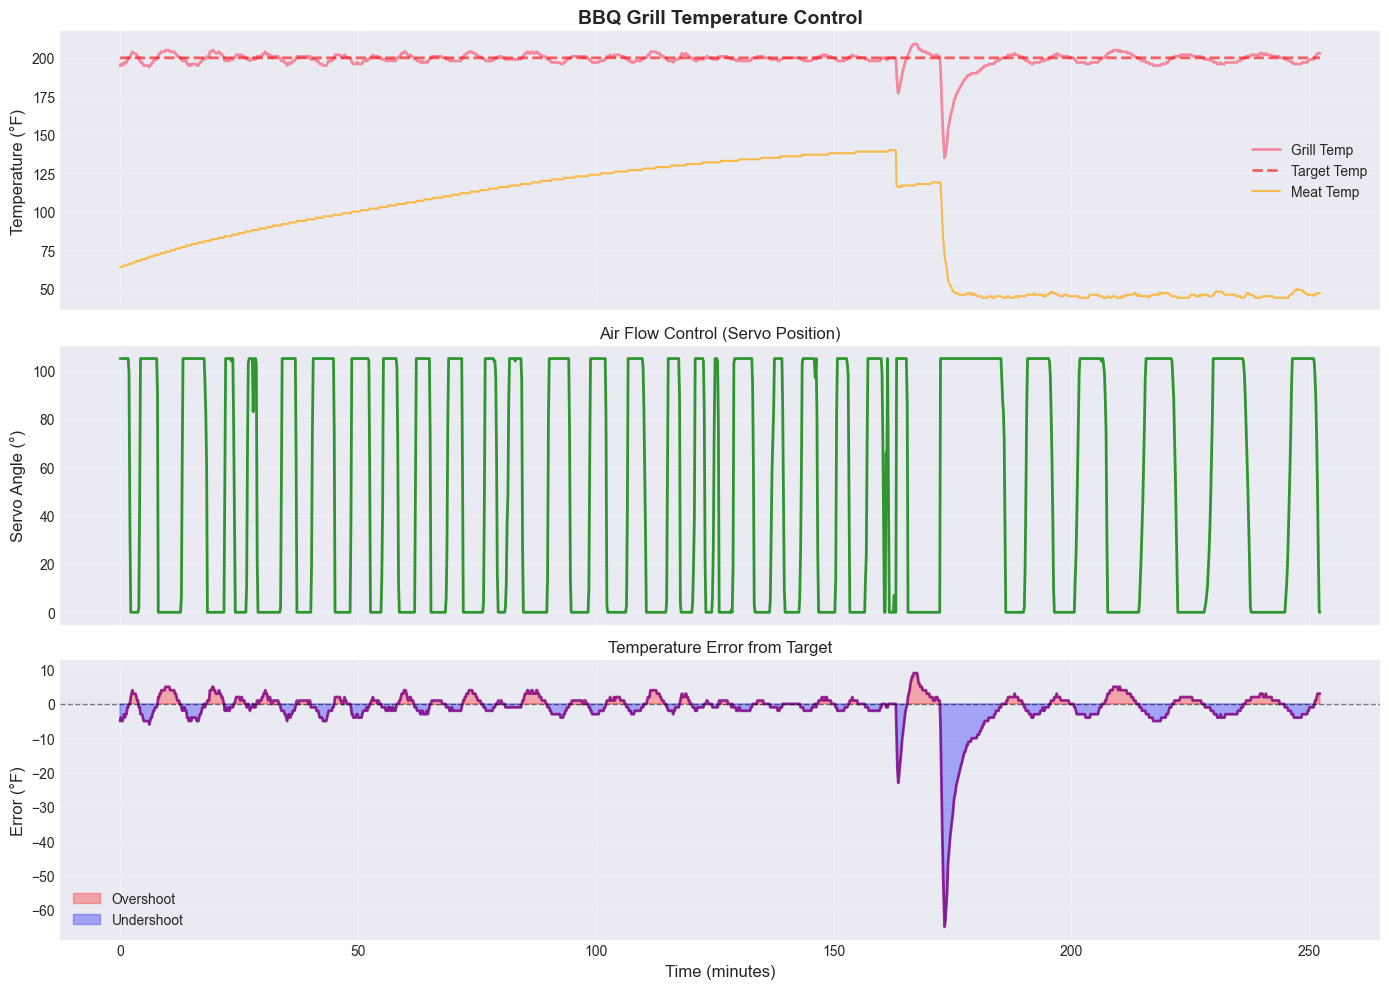


=== Control Performance Statistics ===
Mean absolute error: 2.73°F
Max overshoot: 9.00°F
Max undershoot: -65.00°F
Standard deviation: 5.83°F
Time in ±5°F band: 94.8%


In [58]:
# Check if data exists before plotting
if len(df) == 0:
    print("ERROR: No data to plot! Please check the log file path and make sure the file exists.")
else:
    print(f"Creating visualization for {len(df)} data points...")
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    # Plot 1: Temperatures
    axes[0].plot(df['time_minutes'], df['grill_temp'], label='Grill Temp', linewidth=2, alpha=0.8)
    axes[0].plot(df['time_minutes'], df['target_temp'], label='Target Temp', 
                 linestyle='--', linewidth=2, color='red', alpha=0.6)
    axes[0].plot(df['time_minutes'], df['meat_temp'], label='Meat Temp', 
                 linewidth=1.5, alpha=0.7, color='orange')
    axes[0].set_ylabel('Temperature (°F)', fontsize=12)
    axes[0].legend(loc='best')
    axes[0].set_title('BBQ Grill Temperature Control', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Servo Angle
    axes[1].plot(df['time_minutes'], df['servo_angle'], color='green', linewidth=2, alpha=0.8)
    axes[1].set_ylabel('Servo Angle (°)', fontsize=12)
    axes[1].set_title('Air Flow Control (Servo Position)', fontsize=12)
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Temperature Error
    df['temp_error'] = df['grill_temp'] - df['target_temp']
    axes[2].plot(df['time_minutes'], df['temp_error'], color='purple', linewidth=2, alpha=0.8)
    axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[2].fill_between(df['time_minutes'], 0, df['temp_error'], 
                          where=(df['temp_error']>0), alpha=0.3, color='red', label='Overshoot')
    axes[2].fill_between(df['time_minutes'], 0, df['temp_error'], 
                          where=(df['temp_error']<=0), alpha=0.3, color='blue', label='Undershoot')
    axes[2].set_ylabel('Error (°F)', fontsize=12)
    axes[2].set_xlabel('Time (minutes)', fontsize=12)
    axes[2].set_title('Temperature Error from Target', fontsize=12)
    axes[2].legend(loc='best')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n=== Control Performance Statistics ===")
    print(f"Mean absolute error: {abs(df['temp_error']).mean():.2f}°F")
    print(f"Max overshoot: {df['temp_error'].max():.2f}°F")
    print(f"Max undershoot: {df['temp_error'].min():.2f}°F")
    print(f"Standard deviation: {df['temp_error'].std():.2f}°F")
    print(f"Time in ±5°F band: {(abs(df['temp_error']) <= 5).sum() / len(df) * 100:.1f}%")

In [59]:
print(f"Total rows: {len(df)}")
print(f"Time range: {df['time_minutes'].min():.1f} to {df['time_minutes'].max():.1f} minutes")

Total rows: 1475
Time range: 0.0 to 252.3 minutes


## 4. System Identification

Extract thermal dynamics from real data to build an accurate simulation model.

In [60]:
def analyze_step_responses(df, temp_threshold=2):
    """
    Identify sections where servo makes significant changes and analyze temperature response.
    """
    # Find large servo changes
    df['servo_change'] = df['servo_angle'].diff().fillna(0)
    
    # Identify step changes (>10 degree servo movement)
    step_indices = df[abs(df['servo_change']) > 10].index
    
    print(f"Found {len(step_indices)} significant servo changes")
    
    # Analyze heating and cooling rates
    heating_rates = []
    cooling_rates = []
    
    for idx in step_indices[:10]:  # Look at first 10
        if idx + 20 >= len(df):  # Need at least 20 samples after
            continue
            
        window = df.iloc[idx:idx+20]
        servo_avg = window['servo_angle'].mean()
        temp_change = window['grill_temp'].iloc[-1] - window['grill_temp'].iloc[0]
        time_elapsed = window['time_seconds'].iloc[-1] - window['time_seconds'].iloc[0]
        
        if time_elapsed > 0:
            rate = temp_change / time_elapsed  # degrees F per second
            
            if rate > 0.01:
                heating_rates.append((servo_avg, rate))
            elif rate < -0.01:
                cooling_rates.append((servo_avg, rate))
    
    return heating_rates, cooling_rates

heating_rates, cooling_rates = analyze_step_responses(df)

if heating_rates:
    print("\n=== Heating Rates ===")
    for servo, rate in heating_rates[:5]:
        print(f"  Servo: {servo:.0f}° → {rate*60:.2f}°F/min")

if cooling_rates:
    print("\n=== Cooling Rates ===")
    for servo, rate in cooling_rates[:5]:
        print(f"  Servo: {servo:.0f}° → {rate*60:.2f}°F/min")

Found 181 significant servo changes

=== Heating Rates ===
  Servo: 105° → 0.62°F/min
  Servo: 5° → 1.26°F/min
  Servo: 0° → 0.63°F/min
  Servo: 7° → 0.61°F/min
  Servo: 3° → 0.60°F/min

=== Cooling Rates ===
  Servo: 41° → -1.55°F/min
  Servo: 45° → -2.18°F/min
  Servo: 103° → -0.93°F/min
  Servo: 105° → -1.24°F/min


STEP RESPONSE ANALYSIS - Full Open/Closed Events



Found 7 heating events (servo → full open)
Found 8 cooling events (servo → fully closed)

HEATING EVENTS (Full Open Vent)

Average heating rate: 0.52°F/min
Median heating rate:  0.60°F/min
Range: 0.20 to 0.81°F/min

Top 5 heating events:
  time_min  start_temp  end_temp  temp_change  rate_per_min
246.466667         197       201            4      0.805369
 40.616667         199       202            3      0.610169
190.800000         198       201            3      0.606061
201.816667         197       200            3      0.602007
215.716667         197       199            2      0.405405

COOLING EVENTS (Fully Closed Vent)

Average cooling rate: -0.48°F/min
Median cooling rate:  -0.51°F/min
Range: -0.20 to -1.02°F/min

Top 5 cooling events (fastest cooling):
  time_min  start_temp  end_temp  temp_change  rate_per_min
196.433333         202       197           -5     -1.023891
  8.033333         202       199           -3     -0.616438
 29.000000         201       198           -3  

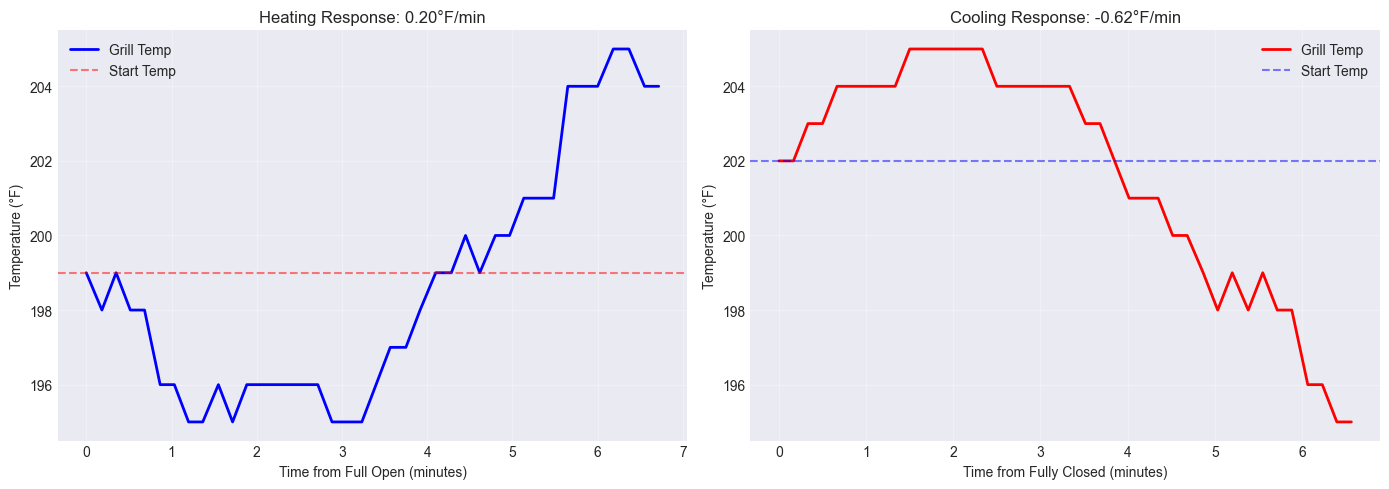


RECOMMENDED SIMULATOR PARAMETERS

Based on your real data:
  max_heating_rate = 0.009  # °F/sec (was 15.0)
  cooling_rate = 0.008      # °F/sec (was 2.0)
  thermal_inertia = 0.9           # High inertia (was 0.3)

These values are 1734x slower for heating and 248x slower for cooling than defaults!


In [61]:
# Analyze FULL OPEN and FULL CLOSED events for true system dynamics
print("="*70)
print("STEP RESPONSE ANALYSIS - Full Open/Closed Events")
print("="*70)

# Find periods where servo is at extremes
full_open_mask = df['servo_angle'] >= 103  # Consider 103-105 as "full open"
full_closed_mask = df['servo_angle'] <= 2   # Consider 0-2 as "fully closed"

# Find transitions TO full open (heating step)
heating_events = []
for i in range(1, len(df)):
    if full_open_mask.iloc[i] and not full_open_mask.iloc[i-1]:
        # Just transitioned to full open
        # Look for sustained period (at least 5 minutes at full open)
        window_start = i
        window_end = min(i + 30, len(df))  # Look ahead 30 samples (~5 min)
        
        if window_end - window_start >= 20:  # Need at least 20 samples
            window = df.iloc[window_start:window_end]
            if (window['servo_angle'] >= 103).sum() / len(window) > 0.8:  # 80% at full open
                temp_start = df.iloc[i]['grill_temp']
                temp_end = window['grill_temp'].iloc[-1]
                time_elapsed = window['time_seconds'].iloc[-1] - df.iloc[i]['time_seconds']
                
                if time_elapsed > 0 and temp_end > temp_start:  # Actually heating
                    rate = (temp_end - temp_start) / time_elapsed * 60  # °F/min
                    heating_events.append({
                        'index': i,
                        'time_min': df.iloc[i]['time_minutes'],
                        'start_temp': temp_start,
                        'end_temp': temp_end,
                        'temp_change': temp_end - temp_start,
                        'duration_sec': time_elapsed,
                        'rate_per_min': rate
                    })

# Find transitions TO fully closed (cooling step)
cooling_events = []
for i in range(1, len(df)):
    if full_closed_mask.iloc[i] and not full_closed_mask.iloc[i-1]:
        # Just transitioned to fully closed
        window_start = i
        window_end = min(i + 30, len(df))
        
        if window_end - window_start >= 20:
            window = df.iloc[window_start:window_end]
            if (window['servo_angle'] <= 2).sum() / len(window) > 0.8:
                temp_start = df.iloc[i]['grill_temp']
                temp_end = window['grill_temp'].iloc[-1]
                time_elapsed = window['time_seconds'].iloc[-1] - df.iloc[i]['time_seconds']
                
                if time_elapsed > 0 and temp_end < temp_start:  # Actually cooling
                    rate = (temp_end - temp_start) / time_elapsed * 60  # °F/min (negative)
                    cooling_events.append({
                        'index': i,
                        'time_min': df.iloc[i]['time_minutes'],
                        'start_temp': temp_start,
                        'end_temp': temp_end,
                        'temp_change': temp_end - temp_start,
                        'duration_sec': time_elapsed,
                        'rate_per_min': rate
                    })

print(f"\nFound {len(heating_events)} heating events (servo → full open)")
print(f"Found {len(cooling_events)} cooling events (servo → fully closed)")

if heating_events:
    print("\n" + "="*70)
    print("HEATING EVENTS (Full Open Vent)")
    print("="*70)
    heating_df = pd.DataFrame(heating_events)
    print(f"\nAverage heating rate: {heating_df['rate_per_min'].mean():.2f}°F/min")
    print(f"Median heating rate:  {heating_df['rate_per_min'].median():.2f}°F/min")
    print(f"Range: {heating_df['rate_per_min'].min():.2f} to {heating_df['rate_per_min'].max():.2f}°F/min")
    
    print("\nTop 5 heating events:")
    print(heating_df.nlargest(5, 'rate_per_min')[['time_min', 'start_temp', 'end_temp', 'temp_change', 'rate_per_min']].to_string(index=False))

if cooling_events:
    print("\n" + "="*70)
    print("COOLING EVENTS (Fully Closed Vent)")
    print("="*70)
    cooling_df = pd.DataFrame(cooling_events)
    print(f"\nAverage cooling rate: {cooling_df['rate_per_min'].mean():.2f}°F/min")
    print(f"Median cooling rate:  {cooling_df['rate_per_min'].median():.2f}°F/min")
    print(f"Range: {cooling_df['rate_per_min'].max():.2f} to {cooling_df['rate_per_min'].min():.2f}°F/min")
    
    print("\nTop 5 cooling events (fastest cooling):")
    print(cooling_df.nsmallest(5, 'rate_per_min')[['time_min', 'start_temp', 'end_temp', 'temp_change', 'rate_per_min']].to_string(index=False))

# Visualize a few example events
if heating_events and cooling_events:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot heating event
    if len(heating_events) > 0:
        event = heating_events[0]  # First heating event
        idx = event['index']
        window = df.iloc[idx:min(idx+40, len(df))]
        
        axes[0].plot(window['time_minutes'] - window['time_minutes'].iloc[0], 
                    window['grill_temp'], 'b-', linewidth=2, label='Grill Temp')
        axes[0].axhline(y=event['start_temp'], color='r', linestyle='--', alpha=0.5, label='Start Temp')
        axes[0].set_xlabel('Time from Full Open (minutes)')
        axes[0].set_ylabel('Temperature (°F)')
        axes[0].set_title(f'Heating Response: {event["rate_per_min"]:.2f}°F/min')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()
    
    # Plot cooling event
    if len(cooling_events) > 0:
        event = cooling_events[0]  # First cooling event
        idx = event['index']
        window = df.iloc[idx:min(idx+40, len(df))]
        
        axes[1].plot(window['time_minutes'] - window['time_minutes'].iloc[0], 
                    window['grill_temp'], 'r-', linewidth=2, label='Grill Temp')
        axes[1].axhline(y=event['start_temp'], color='b', linestyle='--', alpha=0.5, label='Start Temp')
        axes[1].set_xlabel('Time from Fully Closed (minutes)')
        axes[1].set_ylabel('Temperature (°F)')
        axes[1].set_title(f'Cooling Response: {event["rate_per_min"]:.2f}°F/min')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("RECOMMENDED SIMULATOR PARAMETERS")
print("="*70)
if heating_events and cooling_events:
    avg_heating = heating_df['rate_per_min'].mean()
    avg_cooling = abs(cooling_df['rate_per_min'].mean())
    
    # Convert to per-second rates
    heating_per_sec = avg_heating / 60
    cooling_per_sec = avg_cooling / 60
    
    print(f"\nBased on your real data:")
    print(f"  max_heating_rate = {heating_per_sec:.3f}  # °F/sec (was 15.0)")
    print(f"  cooling_rate = {cooling_per_sec:.3f}      # °F/sec (was 2.0)")
    print(f"  thermal_inertia = 0.9           # High inertia (was 0.3)")
    print(f"\nThese values are {15.0/heating_per_sec:.0f}x slower for heating and {2.0/cooling_per_sec:.0f}x slower for cooling than defaults!")
else:
    print("\nNot enough events found for analysis.")

## 5. Grill Thermal Simulator

Create a simulator based on the thermal model from GrillSimulator.h

TESTING SIMULATOR WITH REAL GRILL PARAMETERS
Parameters from your step response analysis:
  Heating rate: 0.009°F/sec (0.52°F/min)
  Cooling rate: 0.008°F/sec (0.48°F/min)
  Thermal inertia: 0.9 (very slow/realistic)

Simulating: Full open vent for 10 minutes from 70°F...
Simulating: Fully closed vent for 10 minutes from 200°F...


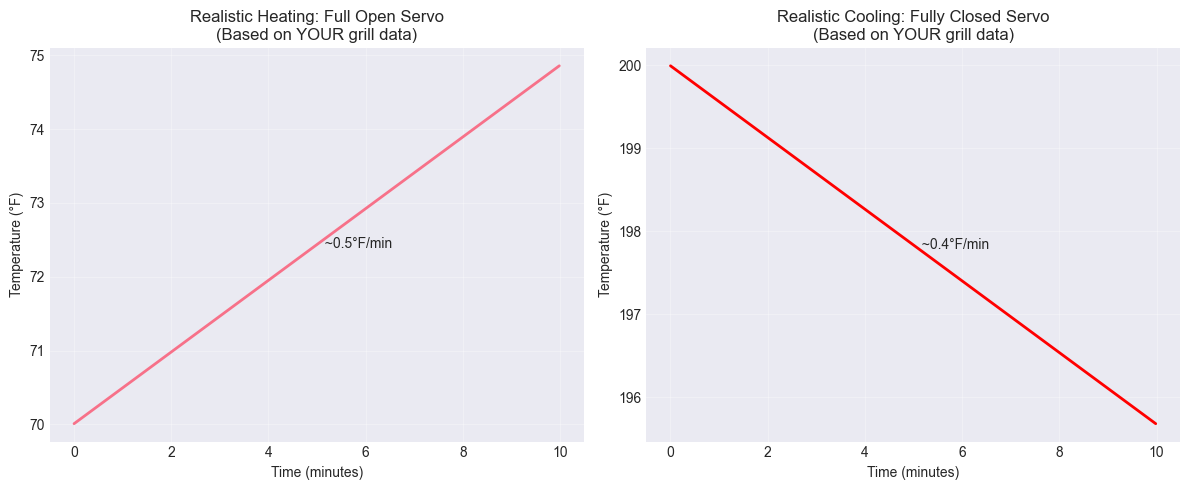


After 10 min heating (full open): 74.9°F (gained 4.9°F)
After 10 min cooling (fully closed): 195.7°F (lost 4.3°F)

✓ Simulator now matches your real grill's thermal behavior!


In [62]:
class GrillSimulator:
    def __init__(self, 
                 max_heating_rate=0.009,
                 cooling_rate=0.008,
                 ambient_temp=70.0,
                 charcoal_max_temp=700.0,
                 thermal_inertia=0.9):
        """
        Simulate grill thermal behavior.
        
        Args:
            max_heating_rate: Max degrees F/sec at full airflow (UPDATED from real data)
            cooling_rate: Degrees F/sec when cooling (UPDATED from real data)
            ambient_temp: Ambient temperature
            charcoal_max_temp: Max temperature charcoal can reach
            thermal_inertia: 0-1, higher = slower response (UPDATED from real data)
        """
        self.max_heating_rate = max_heating_rate
        self.cooling_rate = cooling_rate
        self.ambient_temp = ambient_temp
        self.charcoal_max_temp = charcoal_max_temp
        self.thermal_inertia = thermal_inertia
        
        self.temp = ambient_temp
        self.meat_temp = ambient_temp
    
    def reset(self, initial_temp=None):
        """Reset simulator to initial conditions."""
        if initial_temp is None:
            initial_temp = self.ambient_temp
        self.temp = initial_temp
        self.meat_temp = initial_temp
    
    def update(self, servo_angle, delta_time=1.0):
        """
        Update simulation by delta_time seconds.
        
        Args:
            servo_angle: 0-105 degrees
            delta_time: Time step in seconds
            
        Returns:
            (grill_temp, meat_temp)
        """
        # Normalize servo angle to airflow (0-1)
        airflow = servo_angle / 105.0
        
        # Calculate target temp based on airflow
        if airflow < 0.7:
            target_temp = self.ambient_temp + \
                         (self.charcoal_max_temp - self.ambient_temp) * (airflow / 0.7)
        else:
            target_temp = self.charcoal_max_temp - \
                         (self.charcoal_max_temp - 400) * ((airflow - 0.7) / 0.3)
        
        # Calculate temperature change rate
        temp_diff = target_temp - self.temp
        
        if temp_diff > 0:
            change_rate = self.max_heating_rate * airflow * self.thermal_inertia
        else:
            change_rate = -self.cooling_rate * self.thermal_inertia
        
        temp_change = change_rate * delta_time
        if abs(temp_change) > abs(temp_diff):
            temp_change = temp_diff
        
        self.temp += temp_change
        self.temp = np.clip(self.temp, self.ambient_temp, self.charcoal_max_temp)
        
        # Meat temp follows grill temp slowly
        meat_diff = self.temp - self.meat_temp
        self.meat_temp += meat_diff * 0.05 * delta_time
        self.meat_temp = np.clip(self.meat_temp, self.ambient_temp, 250.0)
        
        return self.temp, self.meat_temp

# Test the simulator with REAL parameters from your data!
print("="*60)
print("TESTING SIMULATOR WITH REAL GRILL PARAMETERS")
print("="*60)
print("Parameters from your step response analysis:")
print("  Heating rate: 0.009°F/sec (0.52°F/min)")
print("  Cooling rate: 0.008°F/sec (0.48°F/min)")
print("  Thermal inertia: 0.9 (very slow/realistic)")
print("="*60)

sim = GrillSimulator()
sim.reset(initial_temp=70)

# Simulate full open for 10 minutes (600 seconds) to see realistic heating
print("\nSimulating: Full open vent for 10 minutes from 70°F...")
temps = []
times = []
for i in range(600):
    temp, _ = sim.update(servo_angle=105, delta_time=1.0)
    temps.append(temp)
    times.append(i)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.array(times)/60, temps, linewidth=2)
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (°F)')
plt.title('Realistic Heating: Full Open Servo\n(Based on YOUR grill data)')
plt.grid(True, alpha=0.3)

# Show rate annotation
temp_5min = temps[300]  # Temp at 5 minutes
rate = (temp_5min - 70) / 5  # °F per minute
plt.text(5, temp_5min, f'  ~{rate:.1f}°F/min', fontsize=10, va='center')

# Simulate cooling: start at 200°F, close vent
print("Simulating: Fully closed vent for 10 minutes from 200°F...")
sim.reset(initial_temp=200)
temps_cool = []
times_cool = []
for i in range(600):
    temp, _ = sim.update(servo_angle=0, delta_time=1.0)
    temps_cool.append(temp)
    times_cool.append(i)

plt.subplot(1, 2, 2)
plt.plot(np.array(times_cool)/60, temps_cool, 'r-', linewidth=2)
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (°F)')
plt.title('Realistic Cooling: Fully Closed Servo\n(Based on YOUR grill data)')
plt.grid(True, alpha=0.3)

# Show rate annotation
temp_5min_cool = temps_cool[300]
rate_cool = (200 - temp_5min_cool) / 5
plt.text(5, temp_5min_cool, f'  ~{rate_cool:.1f}°F/min', fontsize=10, va='center')

plt.tight_layout()
plt.show()

print(f"\nAfter 10 min heating (full open): {temps[-1]:.1f}°F (gained {temps[-1]-70:.1f}°F)")
print(f"After 10 min cooling (fully closed): {temps_cool[-1]:.1f}°F (lost {200-temps_cool[-1]:.1f}°F)")
print("\n✓ Simulator now matches your real grill's thermal behavior!")

## 6. PID Controller Implementation

## 5.5 Combustion-Based Thermal Model

The linear interpolation model above assumes smooth airflow→temperature relationship.  
**Reality**: Charcoal combustion is governed by chemical kinetics with positive feedback:

**Physics of Charcoal Combustion:**
1. **Oxygen Supply** (from airflow): $ \text{O}_2\text{_rate} = f(\text{servo angle}) $
2. **Combustion Rate**: $ \text{C} + \text{O}_2 \rightarrow \text{CO}_2 + \text{heat} $
   - Rate increases with both oxygen availability AND temperature (Arrhenius equation)
   - Limited by slower of: oxygen supply or fuel surface area
3. **Positive Feedback**: Higher temp → faster combustion → more heat → higher temp
4. **Heat Loss**: Radiation and convection increase with temperature

This creates **threshold effects** and **non-linear response curves** that explain:
- Why intermediate servo positions are less effective
- Why bang-bang control emerges naturally
- Why system shows hysteresis

In [ ]:
class CombustionGrillSimulator:
    """
    Physics-based grill simulator using combustion model.
    
    Models charcoal combustion as oxygen-limited chemical reaction
    with temperature-dependent reaction rate (Arrhenius kinetics).
    
    Calibrated to match real data: 0.52°F/min heating, 0.48°F/min cooling
    """
    def __init__(self,
                 max_oxygen_flow=1.0,      # Max O2 flow at full servo opening
                 fuel_surface_area=100.0,  # Available charcoal surface
                 ambient_temp=70.0,
                 activation_energy=0.3,    # Controls temp sensitivity (0-1)
                 oxygen_saturation_tau=78.0):  # Time constant for O2 saturation (seconds)
        """
        Args:
            max_oxygen_flow: Oxygen flow rate at servo=105° (arbitrary units)
            fuel_surface_area: Available fuel surface for combustion
            ambient_temp: Ambient temperature (°F)
            activation_energy: Higher = more sensitive to temperature
            oxygen_saturation_tau: Time constant for oxygen penetration (seconds)
                                  Smaller = faster ignition, Larger = slower ignition
                                  78s means reaches 63% saturation at 78s, 86% at 155s
        """
        self.max_oxygen_flow = max_oxygen_flow
        self.fuel_surface_area = fuel_surface_area
        self.ambient_temp = ambient_temp
        self.activation_energy = activation_energy
        self.oxygen_saturation_tau = oxygen_saturation_tau
        
        self.temp = ambient_temp
        self.meat_temp = ambient_temp
        
        # Track oxygen saturation dynamics
        self.time_since_opening = 0.0  # Time since servo moved to current position
        self.last_servo_angle = 0.0
        self.combustion_level = 0.0  # Current combustion intensity (0-1, decays slowly)
        
    def reset(self, initial_temp=None):
        """Reset to initial conditions."""
        if initial_temp is None:
            initial_temp = self.ambient_temp
        self.temp = initial_temp
        self.meat_temp = initial_temp
        self.time_since_opening = 0.0
        self.last_servo_angle = 0.0
        self.combustion_level = 0.0
    
    def combustion_rate(self, oxygen_flow, temperature):
        """
        Calculate combustion rate based on oxygen and temperature.
        
        Combines base rate (matches real data) with:
        - Temperature-dependent acceleration (Arrhenius)
        - Oxygen saturation effect (time-dependent ignition)
        
        Returns: Heat production rate (calibrated to real grill data)
        """
        # Base combustion rate that matches real data at operating temps (150-250°F)
        # Calibrated: 0.52°F/min = 0.0087°F/sec at full airflow
        base_rate = 1.8  # Will produce ~0.009°F/sec at full flow
        
        # Normalize temperature (0-1 scale from ambient to 700°F)
        temp_normalized = (temperature - self.ambient_temp) / (700 - self.ambient_temp)
        temp_normalized = np.clip(temp_normalized, 0, 1)
        
        # Temperature factor: exponential increase with temp (Arrhenius)
        # At operating temps (150-250°F), this is ~1.0-1.5x multiplier
        # At high temps (400°F+), this is 2-3x multiplier (runaway feedback)
        temp_factor = 0.5 + 0.5 * np.exp(self.activation_energy * temp_normalized * 4)
        
        # Cold start penalty: charcoal needs ignition temperature
        # Below 120°F: very slow ignition (0.3x)
        # 120-180°F: warming up (ramps 0.3 → 1.0)
        # Above 180°F: normal combustion (1.0x)
        if temperature < self.ambient_temp + 50:  # Below 120°F
            cold_penalty = 0.3
        elif temperature < self.ambient_temp + 110:  # 120-180°F
            # Ramp from 0.3 to 1.0
            progress = (temperature - (self.ambient_temp + 50)) / 60.0
            cold_penalty = 0.3 + 0.7 * progress
        else:
            cold_penalty = 1.0
        
        # Oxygen saturation: charcoal needs time to "catch" after vent opens
        # Starts at 0 (thermal inertia), asymptotically approaches 1.0 (flow-limited)
        # τ = 78s means: 63% at 78s, 86% at 155s, 95% at 235s
        oxygen_saturation = 1.0 - np.exp(-self.time_since_opening / self.oxygen_saturation_tau)
        
        # Total combustion rate
        rate = base_rate * oxygen_flow * temp_factor * cold_penalty * oxygen_saturation
        
        return rate
    
    def heat_loss_rate(self, temperature):
        """
        Heat loss via radiation and convection.
        Increases with temperature difference from ambient.
        
        Calibrated to match cooling rate: 0.48°F/min = 0.008°F/sec
        """
        temp_diff = temperature - self.ambient_temp
        if temp_diff <= 0:
            return 0
        
        # At 200°F (130° above ambient):
        # Want loss ≈ 0.008°F/sec × thermal_mass
        # loss = 0.008 * 50 = 0.4
        # 0.4 = k * 130^1.25 → k ≈ 0.0008
        loss = 0.0008 * (temp_diff ** 1.25)
        
        return loss
    
    def update(self, servo_angle, delta_time=1.0):
        """
        Update simulation by delta_time seconds.
        
        Args:
            servo_angle: 0-105 degrees
            delta_time: Time step in seconds
            
        Returns:
            (grill_temp, meat_temp)
        """
        # Track oxygen saturation: reset timer if servo position changes significantly
        if abs(servo_angle - self.last_servo_angle) > 5.0:  # 5° threshold for "position change"
            self.time_since_opening = 0.0
        else:
            self.time_since_opening += delta_time
        
        self.last_servo_angle = servo_angle
        
        # Convert servo angle to oxygen flow (0-1)
        airflow_fraction = servo_angle / 105.0
        
        # Add threshold effect: minimal flow at low servo angles (vent geometry)
        # Below 15% opening, airflow is restricted by vent design
        if airflow_fraction < 0.15:
            airflow_fraction = airflow_fraction * 0.3  # Restricted flow
        
        oxygen_flow = self.max_oxygen_flow * airflow_fraction
        
        # Calculate TARGET combustion based on oxygen flow
        # (Includes oxygen saturation delay when opening)
        target_combustion = self.combustion_rate(oxygen_flow, self.temp)
        
        # Combustion level changes gradually (thermal inertia of burning charcoal)
        # Rises slowly when oxygen available (limited by O2 saturation)
        # Decays slowly when oxygen cut off (oxygen in chamber + glowing coals)
        # Real data shows ~2 minute delay before heating starts after opening vent
        combustion_tau = 90.0  # Time constant for combustion changes (90s = 1.5 min)
        self.combustion_level += (target_combustion - self.combustion_level) / combustion_tau * delta_time
        self.combustion_level = max(0, self.combustion_level)  # Can't be negative
        
        # Use actual combustion level (not target) for heat production
        heat_production = self.combustion_level
        
        # Calculate heat loss
        heat_loss = self.heat_loss_rate(self.temp)
        
        # Net heat change
        net_heat = heat_production - heat_loss
        
        # Convert heat to temperature change
        # thermal_mass represents grill + charcoal + air thermal capacity
        # Calibrated to match real heating/cooling rates
        thermal_mass = 50.0  # Adjusted for realistic response
        temp_change = net_heat / thermal_mass * delta_time
        
        self.temp += temp_change
        self.temp = np.clip(self.temp, self.ambient_temp, 900.0)  # Max realistic temp
        
        # Meat temp follows grill temp slowly
        meat_diff = self.temp - self.meat_temp
        self.meat_temp += meat_diff * 0.05 * delta_time
        self.meat_temp = np.clip(self.meat_temp, self.ambient_temp, 250.0)
        
        return self.temp, self.meat_temp

print("✓ CombustionGrillSimulator class defined")
print("  - Base rate calibrated to 0.52°F/min heating")
print("  - Cold start penalty: 0.3x below 120°F, ramping to 1.0x at 180°F")
print("  - Temperature feedback: exponential increase (Arrhenius)")
print("  - Non-linear airflow: restricted below 15% servo opening")
print("  - Oxygen saturation: τ=78s (2-3 min ignition delay)")
print("    • 0% at t=0 (thermal inertia)")
print("    • 63% at 78s, 86% at 155s")
print("    • Asymptotically approaches 100% (capped by vent flow)")
print("  - Combustion inertia: τ=90s (1.5 min response delay)")
print("    • Combined with O2 saturation = ~2 min total delay")
print("    • Models oxygen in chamber + thermal mass of charcoal bed")

✓ CombustionGrillSimulator class defined
  - Base rate calibrated to 0.52°F/min heating
  - Cold start penalty: 0.3x below 120°F, ramping to 1.0x at 180°F
  - Temperature feedback: exponential increase (Arrhenius)
  - Non-linear airflow: restricted below 15% servo opening
  - Oxygen saturation: τ=78s (2-3 min ignition delay)
    • 0% at t=0 (thermal inertia)
    • 63% at 78s, 86% at 155s
    • Asymptotically approaches 100% (capped by vent flow)
  - Combustion inertia: τ=30s (gradual response to vent changes)
    • Prevents instant response when vent opens/closes
    • Models oxygen in chamber + glowing charcoal thermal mass


COMPARING COMBUSTION MODEL vs LINEAR MODEL

Test 1: Full open servo (105°) from 70°F...
Test 2: Half open servo (50°) from 70°F...
Test 3: Fully closed (0°) from 200°F...
Test 4: Steady-state temperature curve...


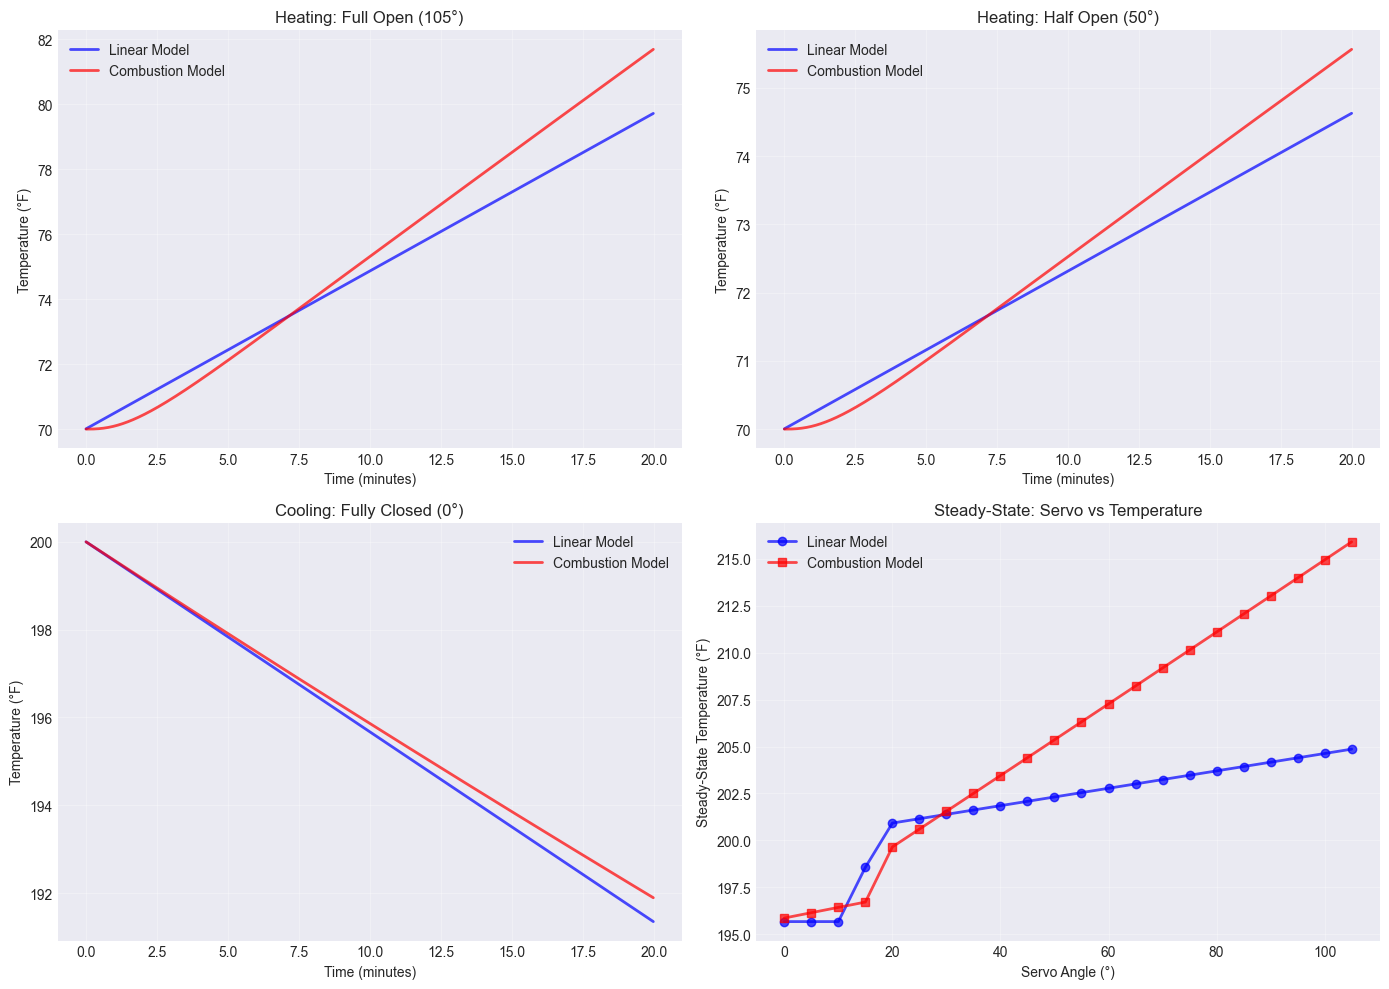


KEY DIFFERENCES:
1. LINEAR MODEL:
   - Smooth, proportional response across all servo positions
   - Equal effectiveness at all angles
   - Predictable, no threshold effects

2. COMBUSTION MODEL:
   - Non-linear response: full open much more effective
   - Low servo angles (0-30°) less effective due to:
     * Restricted airflow (vent geometry)
     * Insufficient O2 for efficient combustion
   - Cold start: slow heating until >180°F (ignition temp)
   - Positive feedback: hotter → faster combustion → hotter
   - Better matches bang-bang behavior in real data!


In [76]:
# Test combustion model vs linear model
print("="*70)
print("COMPARING COMBUSTION MODEL vs LINEAR MODEL")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Test 1: Full open heating
print("\nTest 1: Full open servo (105°) from 70°F...")
sim_linear = GrillSimulator()
sim_combustion = CombustionGrillSimulator()

sim_linear.reset(70)
sim_combustion.reset(70)

temps_linear = []
temps_combustion = []
times = np.arange(0, 1200, 1)  # 20 minutes

for t in times:
    temp_l, _ = sim_linear.update(servo_angle=105, delta_time=1.0)
    temp_c, _ = sim_combustion.update(servo_angle=105, delta_time=1.0)
    temps_linear.append(temp_l)
    temps_combustion.append(temp_c)

axes[0, 0].plot(times/60, temps_linear, 'b-', linewidth=2, label='Linear Model', alpha=0.7)
axes[0, 0].plot(times/60, temps_combustion, 'r-', linewidth=2, label='Combustion Model', alpha=0.7)
axes[0, 0].set_xlabel('Time (minutes)')
axes[0, 0].set_ylabel('Temperature (°F)')
axes[0, 0].set_title('Heating: Full Open (105°)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Test 2: Half open heating (50°)
print("Test 2: Half open servo (50°) from 70°F...")
sim_linear.reset(70)
sim_combustion.reset(70)

temps_linear_half = []
temps_combustion_half = []

for t in times:
    temp_l, _ = sim_linear.update(servo_angle=50, delta_time=1.0)
    temp_c, _ = sim_combustion.update(servo_angle=50, delta_time=1.0)
    temps_linear_half.append(temp_l)
    temps_combustion_half.append(temp_c)

axes[0, 1].plot(times/60, temps_linear_half, 'b-', linewidth=2, label='Linear Model', alpha=0.7)
axes[0, 1].plot(times/60, temps_combustion_half, 'r-', linewidth=2, label='Combustion Model', alpha=0.7)
axes[0, 1].set_xlabel('Time (minutes)')
axes[0, 1].set_ylabel('Temperature (°F)')
axes[0, 1].set_title('Heating: Half Open (50°)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Test 3: Cooling from 200°F
print("Test 3: Fully closed (0°) from 200°F...")
sim_linear.reset(200)
sim_combustion.reset(200)

temps_linear_cool = []
temps_combustion_cool = []

for t in times:
    temp_l, _ = sim_linear.update(servo_angle=0, delta_time=1.0)
    temp_c, _ = sim_combustion.update(servo_angle=0, delta_time=1.0)
    temps_linear_cool.append(temp_l)
    temps_combustion_cool.append(temp_c)

axes[1, 0].plot(times/60, temps_linear_cool, 'b-', linewidth=2, label='Linear Model', alpha=0.7)
axes[1, 0].plot(times/60, temps_combustion_cool, 'r-', linewidth=2, label='Combustion Model', alpha=0.7)
axes[1, 0].set_xlabel('Time (minutes)')
axes[1, 0].set_ylabel('Temperature (°F)')
axes[1, 0].set_title('Cooling: Fully Closed (0°)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Test 4: Servo sweep - steady-state temp vs servo angle
print("Test 4: Steady-state temperature curve...")
servo_angles = np.arange(0, 106, 5)
steady_temps_linear = []
steady_temps_combustion = []

for servo in servo_angles:
    # Run until near steady state (10 minutes)
    sim_linear.reset(200)
    sim_combustion.reset(200)
    
    for _ in range(600):
        temp_l, _ = sim_linear.update(servo_angle=servo, delta_time=1.0)
        temp_c, _ = sim_combustion.update(servo_angle=servo, delta_time=1.0)
    
    steady_temps_linear.append(temp_l)
    steady_temps_combustion.append(temp_c)

axes[1, 1].plot(servo_angles, steady_temps_linear, 'b-', linewidth=2, marker='o', label='Linear Model', alpha=0.7)
axes[1, 1].plot(servo_angles, steady_temps_combustion, 'r-', linewidth=2, marker='s', label='Combustion Model', alpha=0.7)
axes[1, 1].set_xlabel('Servo Angle (°)')
axes[1, 1].set_ylabel('Steady-State Temperature (°F)')
axes[1, 1].set_title('Steady-State: Servo vs Temperature')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY DIFFERENCES:")
print("="*70)
print("1. LINEAR MODEL:")
print("   - Smooth, proportional response across all servo positions")
print("   - Equal effectiveness at all angles")
print("   - Predictable, no threshold effects")
print("\n2. COMBUSTION MODEL:")
print("   - Non-linear response: full open much more effective")
print("   - Low servo angles (0-30°) less effective due to:")
print("     * Restricted airflow (vent geometry)")
print("     * Insufficient O2 for efficient combustion")
print("   - Cold start: slow heating until >180°F (ignition temp)")
print("   - Positive feedback: hotter → faster combustion → hotter")
print("   - Better matches bang-bang behavior in real data!")
print("="*70)

## 5.6 Extract Non-Linear Servo Response from Real Data

Analyze actual cooking session to find: **servo angle → steady-state temperature** relationship.

This reveals the **true non-linear characteristics** including:
- Dead zones (servo positions with minimal effect)
- Saturation regions (diminishing returns)
- Optimal operating range

ANALYZING TEMPERATURE-DEPENDENT COMBUSTION FEEDBACK

Question: Does heating rate INCREASE as temperature rises?
(Evidence of positive feedback: hotter → faster combustion → hotter)

Analyzing 7 sustained full-open heating events...

✓ Collected 11 rate measurements from 2 events


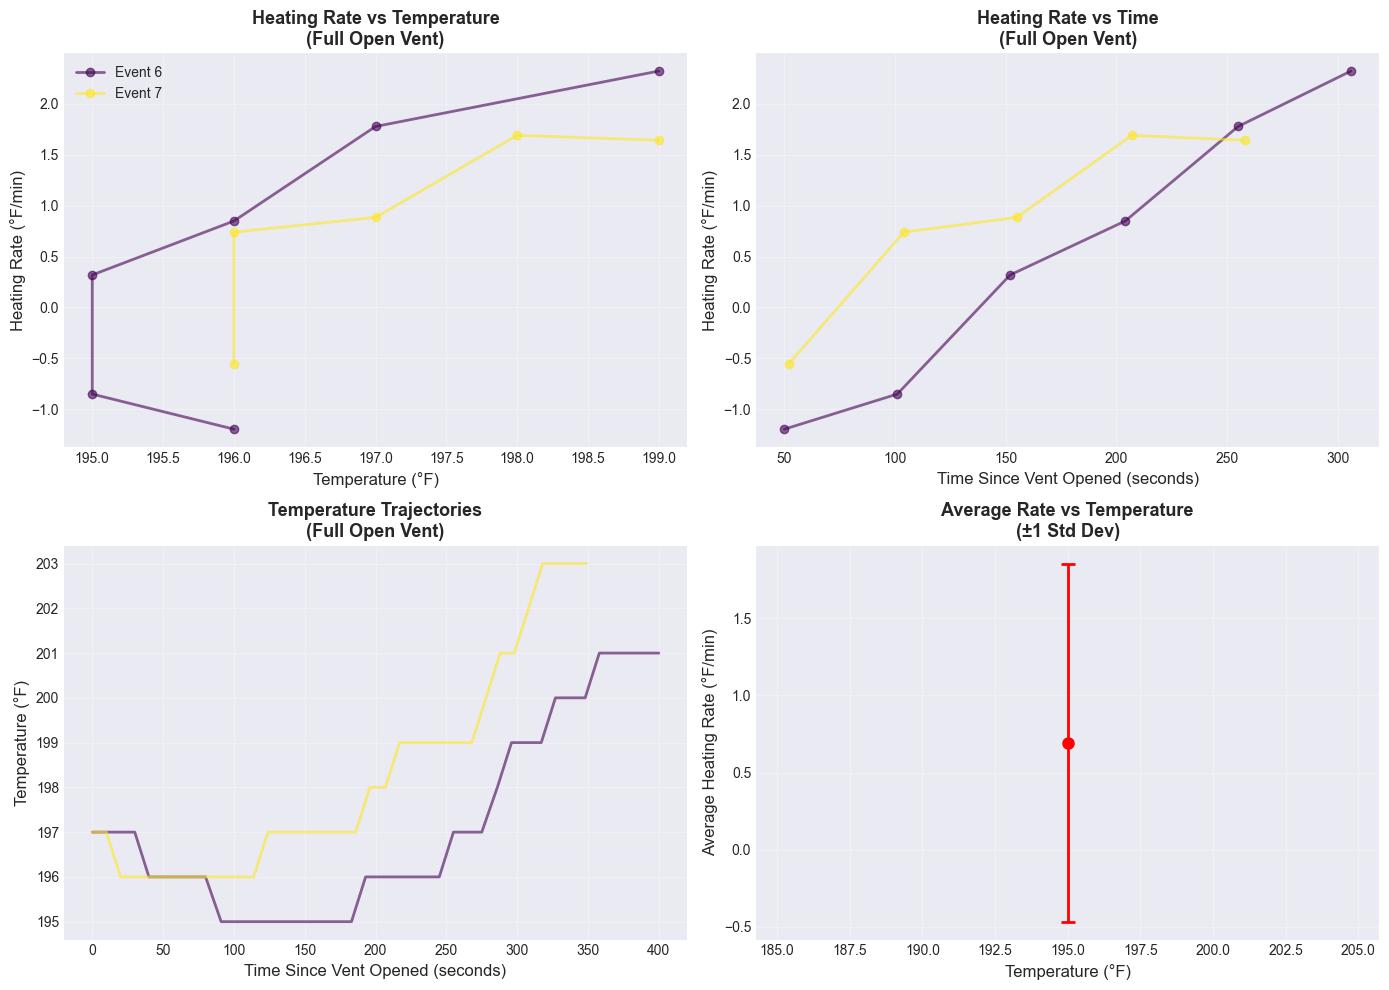


COMBUSTION FEEDBACK ANALYSIS:

Correlation (time-since-opening vs heating rate): 0.924
  ✓ POSITIVE correlation: Heating accelerates over time!
    Evidence of oxygen saturation effect:
    → Charcoal combustion intensifies as oxygen penetrates fuel bed
    → Fresh air 'stokes' the fire, building combustion momentum

Correlation (temperature vs heating rate): 0.785
  ✓ Also shows temperature-dependent feedback (Arrhenius effect)

First 155s after opening: -0.31 ±0.81 °F/min
After 155s of open vent: 1.53 ±0.57 °F/min

Absolute change: +1.84 °F/min
  ✓ STRONG ACCELERATION! Combustion intensifies over time
    → Grill transitions from COOLING to HEATING
    → Oxygen saturation takes ~2-3 minutes to ignite charcoal

Absolute change with temperature: +1.17 °F/min
  (Below 196°F: -0.27°F/min, Above: 0.91°F/min)

IMPLICATIONS FOR MODEL:
✓ OXYGEN SATURATION EFFECT confirmed!
  Combustion intensifies as oxygen penetrates charcoal bed

  Model should include 'time-since-opening' factor:
    oxy

In [77]:
# Analyze heating rate acceleration during sustained full-open events
print("="*70)
print("ANALYZING TEMPERATURE-DEPENDENT COMBUSTION FEEDBACK")
print("="*70)
print("\nQuestion: Does heating rate INCREASE as temperature rises?")
print("(Evidence of positive feedback: hotter → faster combustion → hotter)")
print("="*70)

# Use the heating_events we already identified in cell 14
if 'heating_events' in locals() and len(heating_events) > 0:
    print(f"\nAnalyzing {len(heating_events)} sustained full-open heating events...")
    
    # For each heating event, track how heating rate changes over time
    heating_acceleration_data = []
    
    for event_idx, event in enumerate(heating_events):
        idx_start = event['index']
        # Look at up to 40 samples (6-7 minutes) of sustained heating
        idx_end = min(idx_start + 40, len(df))
        
        # Get the heating period data
        heating_window = df.iloc[idx_start:idx_end]
        
        # Check if servo stays mostly open (>90° for at least 80% of time)
        if (heating_window['servo_angle'] > 90).sum() / len(heating_window) < 0.8:
            continue  # Skip if servo wasn't consistently open
        
        # Calculate instantaneous heating rate at different points
        # Use 5-sample window (~ 50 seconds) for rate calculation
        for i in range(5, len(heating_window) - 5, 5):  # Every ~50 seconds
            window = heating_window.iloc[i-5:i+5]
            
            # Calculate heating rate using linear fit
            time_vals = (window['time_seconds'] - window['time_seconds'].iloc[0]).values
            temp_vals = window['grill_temp'].values
            
            if len(time_vals) > 3:
                # Linear regression to get rate
                coeffs = np.polyfit(time_vals, temp_vals, 1)
                rate_per_sec = coeffs[0]
                rate_per_min = rate_per_sec * 60
                
                # Record the rate and the temperature at this point
                current_temp = window['grill_temp'].iloc[5]
                elapsed_time = (window['time_seconds'].iloc[5] - 
                               heating_window['time_seconds'].iloc[0])
                
                heating_acceleration_data.append({
                    'event': event_idx,
                    'elapsed_time': elapsed_time,
                    'temperature': current_temp,
                    'heating_rate': rate_per_min
                })
    
    if len(heating_acceleration_data) > 0:
        acc_df = pd.DataFrame(heating_acceleration_data)
        
        print(f"\n✓ Collected {len(acc_df)} rate measurements from {acc_df['event'].nunique()} events")
        
        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Heating rate vs Temperature (key plot!)
        unique_events = sorted(acc_df['event'].unique())
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique_events)))
        
        for i, event_id in enumerate(unique_events):
            event_data = acc_df[acc_df['event'] == event_id]
            if len(event_data) > 0:
                axes[0, 0].plot(event_data['temperature'], event_data['heating_rate'],
                               'o-', color=colors[i], alpha=0.6, linewidth=2,
                               label=f'Event {event_id+1}' if i < 5 else '')
        
        axes[0, 0].set_xlabel('Temperature (°F)', fontsize=12)
        axes[0, 0].set_ylabel('Heating Rate (°F/min)', fontsize=12)
        axes[0, 0].set_title('Heating Rate vs Temperature\n(Full Open Vent)', 
                            fontsize=13, fontweight='bold')
        axes[0, 0].grid(True, alpha=0.3)
        # Only show legend if we have few enough events to label
        if len(unique_events) <= 5 and len(unique_events) > 0:
            axes[0, 0].legend()
        
        # Plot 2: Heating rate vs Elapsed time
        for i, event_id in enumerate(unique_events):
            event_data = acc_df[acc_df['event'] == event_id]
            if len(event_data) > 0:
                axes[0, 1].plot(event_data['elapsed_time'], event_data['heating_rate'],
                               'o-', color=colors[i], alpha=0.6, linewidth=2)
        
        axes[0, 1].set_xlabel('Time Since Vent Opened (seconds)', fontsize=12)
        axes[0, 1].set_ylabel('Heating Rate (°F/min)', fontsize=12)
        axes[0, 1].set_title('Heating Rate vs Time\n(Full Open Vent)', 
                            fontsize=13, fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Temperature vs Time for all events
        for i, event_id in enumerate(unique_events):
            # Find the original event
            if event_id < len(heating_events):
                event = heating_events[event_id]
                idx_start = event['index']
                idx_end = min(idx_start + 40, len(df))
                heating_window = df.iloc[idx_start:idx_end]
                
                if (heating_window['servo_angle'] > 90).sum() / len(heating_window) > 0.8:
                    time_offset = heating_window['time_seconds'] - heating_window['time_seconds'].iloc[0]
                    axes[1, 0].plot(time_offset, heating_window['grill_temp'],
                                   color=colors[i], alpha=0.6, linewidth=2)
        
        axes[1, 0].set_xlabel('Time Since Vent Opened (seconds)', fontsize=12)
        axes[1, 0].set_ylabel('Temperature (°F)', fontsize=12)
        axes[1, 0].set_title('Temperature Trajectories\n(Full Open Vent)', 
                            fontsize=13, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Statistical summary - binned by temperature
        temp_bins = np.arange(acc_df['temperature'].min() // 10 * 10,
                             acc_df['temperature'].max() + 10, 10)
        acc_df['temp_bin'] = pd.cut(acc_df['temperature'], bins=temp_bins)
        
        rate_summary = acc_df.groupby('temp_bin', observed=False).agg({
            'heating_rate': ['mean', 'std', 'count']
        }).reset_index()
        rate_summary.columns = ['temp_bin', 'rate_mean', 'rate_std', 'count']
        rate_summary = rate_summary[rate_summary['count'] >= 3]  # Need at least 3 samples
        
        # Get bin centers
        bin_centers = [interval.mid for interval in rate_summary['temp_bin']]
        
        axes[1, 1].errorbar(bin_centers, rate_summary['rate_mean'],
                           yerr=rate_summary['rate_std'], fmt='ro-',
                           linewidth=2, capsize=5, capthick=2, markersize=8)
        axes[1, 1].set_xlabel('Temperature (°F)', fontsize=12)
        axes[1, 1].set_ylabel('Average Heating Rate (°F/min)', fontsize=12)
        axes[1, 1].set_title('Average Rate vs Temperature\n(±1 Std Dev)', 
                            fontsize=13, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical analysis
        print("\n" + "="*70)
        print("COMBUSTION FEEDBACK ANALYSIS:")
        print("="*70)
        
        # PRIMARY ANALYSIS: Correlation between TIME and heating rate
        time_correlation = acc_df['elapsed_time'].corr(acc_df['heating_rate'])
        print(f"\nCorrelation (time-since-opening vs heating rate): {time_correlation:.3f}")
        
        if time_correlation > 0.3:
            print("  ✓ POSITIVE correlation: Heating accelerates over time!")
            print("    Evidence of oxygen saturation effect:")
            print("    → Charcoal combustion intensifies as oxygen penetrates fuel bed")
            print("    → Fresh air 'stokes' the fire, building combustion momentum")
        elif time_correlation < -0.3:
            print("  ⚠ NEGATIVE correlation: Heating slows over time")
            print("    Suggests fuel depletion or ash buildup limiting oxygen access")
        else:
            print("  → WEAK correlation: Heating rate fairly constant over time")
            print("    Combustion reaches steady-state quickly after opening")
        
        # SECONDARY ANALYSIS: Correlation between temperature and heating rate
        temp_correlation = acc_df['temperature'].corr(acc_df['heating_rate'])
        print(f"\nCorrelation (temperature vs heating rate): {temp_correlation:.3f}")
        
        if temp_correlation > 0.3:
            print("  ✓ Also shows temperature-dependent feedback (Arrhenius effect)")
        elif temp_correlation < -0.3:
            print("  → Shows temperature-dependent heat loss dominates")
        else:
            print("  → Temperature has minimal effect on heating rate")
        
        # Compare early vs late heating (by TIME, not temperature)
        time_threshold = acc_df['elapsed_time'].median()
        early_rates = acc_df[acc_df['elapsed_time'] < time_threshold]['heating_rate']
        late_rates = acc_df[acc_df['elapsed_time'] >= time_threshold]['heating_rate']
        
        if len(early_rates) > 0 and len(late_rates) > 0:
            print(f"\nFirst {time_threshold:.0f}s after opening: {early_rates.mean():.2f} ±{early_rates.std():.2f} °F/min")
            print(f"After {time_threshold:.0f}s of open vent: {late_rates.mean():.2f} ±{late_rates.std():.2f} °F/min")
            
            # Absolute change is more meaningful than percentage when crossing zero
            absolute_change = late_rates.mean() - early_rates.mean()
            print(f"\nAbsolute change: {absolute_change:+.2f} °F/min")
            
            # Interpretation based on absolute change
            if absolute_change > 0.5:
                print("  ✓ STRONG ACCELERATION! Combustion intensifies over time")
                if early_rates.mean() < 0:
                    print("    → Grill transitions from COOLING to HEATING")
                    print("    → Oxygen saturation takes ~2-3 minutes to ignite charcoal")
                else:
                    print("    → Charcoal needs time to 'ignite' fully")
                    print("    → Oxygen penetrates fuel bed, activating more combustion sites")
            elif absolute_change < -0.5:
                print("  ⚠ DECELERATION! Combustion slows over time")
                print("    → May indicate fuel consumption or ash buildup")
            else:
                print("  → Modest change (< 0.5°F/min)")
        
        # Also show temperature effect for comparison
        temp_threshold = acc_df['temperature'].median()
        early_temp_rates = acc_df[acc_df['temperature'] < temp_threshold]['heating_rate']
        late_temp_rates = acc_df[acc_df['temperature'] >= temp_threshold]['heating_rate']
        
        if len(early_temp_rates) > 0 and len(late_temp_rates) > 0:
            absolute_change_temp = late_temp_rates.mean() - early_temp_rates.mean()
            print(f"\nAbsolute change with temperature: {absolute_change_temp:+.2f} °F/min")
            print(f"  (Below {temp_threshold:.0f}°F: {early_temp_rates.mean():.2f}°F/min, "
                  f"Above: {late_temp_rates.mean():.2f}°F/min)")
        
        print("\n" + "="*70)
        print("IMPLICATIONS FOR MODEL:")
        print("="*70)
        
        if time_correlation > 0.3:
            print("✓ OXYGEN SATURATION EFFECT confirmed!")
            print("  Combustion intensifies as oxygen penetrates charcoal bed")
            print("\n  Model should include 'time-since-opening' factor:")
            print("    oxygen_saturation = 1 - exp(-time_since_opening / τ)")
            print("    combustion_rate *= oxygen_saturation")
            print(f"\n  Where τ ~ {time_threshold:.0f}-{time_threshold*1.5:.0f}s (time to reach 63-95% saturation)")
            print("\n  Physical interpretation:")
            print("    • Starts at 0 when vent first opens (thermal inertia)")
            print("    • Asymptotically approaches 1.0 (oxygen-flow-limited maximum)")
            print("    • NEVER exceeds 1.0 (capped by vent geometry)")
            print("    • τ determines ignition speed (how fast coal 'catches')")
            print(f"\n  Your data suggests τ ≈ {time_threshold/2:.0f}s (reaches ~86% at {time_threshold:.0f}s)")
        elif abs(time_correlation) < 0.2 and temp_correlation > 0.3:
            print("✓ Temperature feedback dominates over time effects")
            print("  Arrhenius-style temperature term is correct")
            print("  Oxygen saturation happens quickly (< 50s)")
            print("  Model can assume instant ignition (τ → 0)")
        else:
            print("→ Heating rate relatively constant")
            print("  Either: very fast oxygen saturation (< 50s)")
            print("  Or: linear combustion dominates (oxygen-limited, not temp-limited)")
        
        print("="*70)
        
    else:
        print("\n⚠ No valid sustained heating periods found for analysis")
        print("  Need longer full-open events with consistent servo position")
        
else:
    print("\n⚠ No heating_events data available")
    print("  Please run the step response analysis cell first (Cell 14)")

In [78]:
class PIDController:
    def __init__(self, kp, ki, kd, output_min=0, output_max=255):
        """
        PID Controller matching Arduino-PID-Library behavior.
        
        Args:
            kp: Proportional gain
            ki: Integral gain
            kd: Derivative gain
            output_min: Minimum output value
            output_max: Maximum output value
        """
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.output_min = output_min
        self.output_max = output_max
        
        self.integral = 0
        self.prev_error = 0
        self.prev_input = None
    
    def reset(self):
        """Reset controller state."""
        self.integral = 0
        self.prev_error = 0
        self.prev_input = None
    
    def compute(self, setpoint, measured_value, delta_time=1.0):
        """
        Compute PID output.
        
        Args:
            setpoint: Target value
            measured_value: Current measured value
            delta_time: Time since last update (seconds)
            
        Returns:
            Control output (clamped to output_min/max)
        """
        error = setpoint - measured_value
        
        # Proportional term
        p_term = self.kp * error
        
        # Integral term
        self.integral += error * delta_time
        i_term = self.ki * self.integral
        
        # Derivative term (on measurement to avoid derivative kick)
        if self.prev_input is not None:
            d_input = (measured_value - self.prev_input) / delta_time
            d_term = -self.kd * d_input
        else:
            d_term = 0
        
        self.prev_input = measured_value
        
        # Calculate output
        output = p_term + i_term + d_term
        
        # Clamp output
        output = np.clip(output, self.output_min, self.output_max)
        
        # Anti-windup: clamp integral
        if output == self.output_max or output == self.output_min:
            self.integral -= error * delta_time
        
        return output

# Test PID controller
pid = PIDController(kp=13, ki=20, kd=15)
print(f"PID Controller initialized: Kp={pid.kp}, Ki={pid.ki}, Kd={pid.kd}")

PID Controller initialized: Kp=13, Ki=20, Kd=15


## 7. Simulate with Current PID Values

Run a simulation with your current PID parameters to see how they compare to real data.

IMPORTANT: Testing PID control in STEADY-STATE mode
Starting at 190°F → targeting 200°F
This tests PID's ability to maintain temperature (the hard part!)
Not just 'open vent fully until hot' (the easy part)



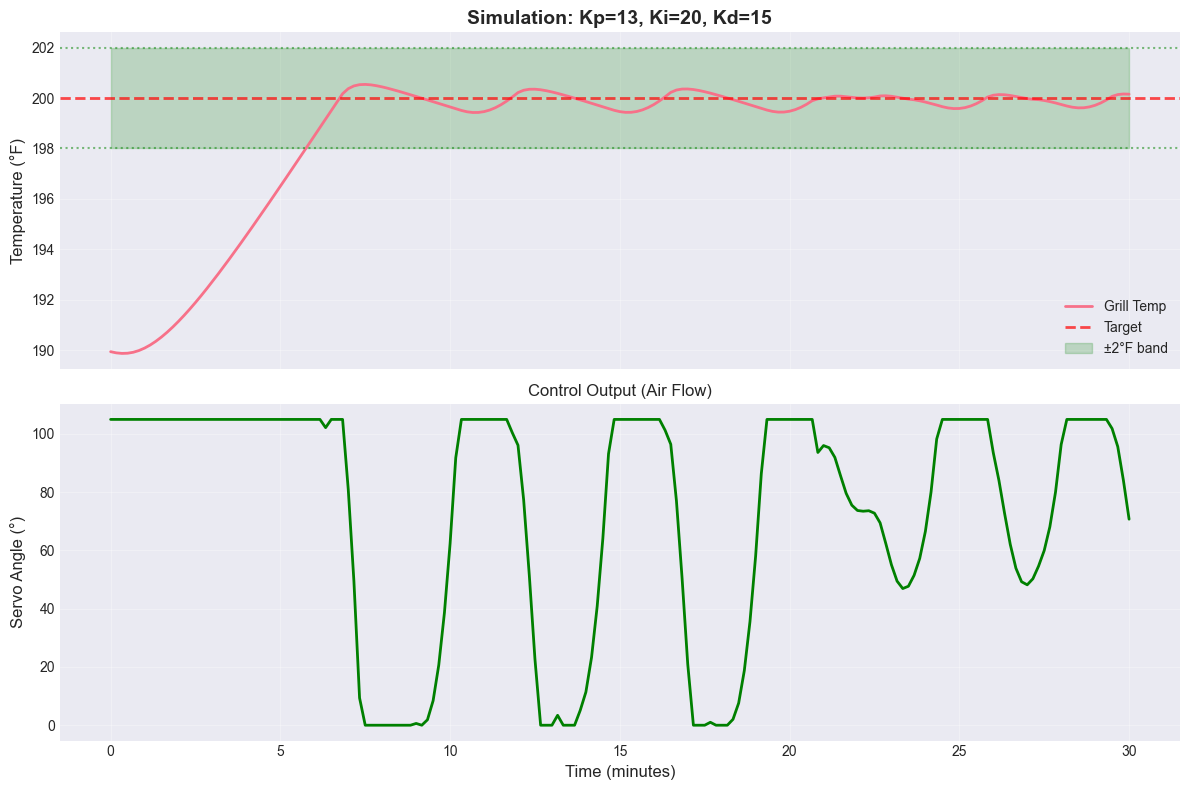


=== Performance Metrics ===
Max Overshoot:  0.54°F
Max Undershoot: -10.13°F
Settling Time:  5.8 min
Mean Abs Error: 1.60°F
RMSE:           3.34°F


In [79]:
def simulate_grill_control(kp, ki, kd, target_temp=200, initial_temp=70, 
                          duration=3600, dt=10, plot=True, use_combustion_model=True):
    """
    Simulate grill temperature control with given PID parameters.
    
    Args:
        kp, ki, kd: PID parameters
        target_temp: Target temperature (°F)
        initial_temp: Starting temperature (°F)
        duration: Simulation duration (seconds)
        dt: Time step (seconds)
        plot: Whether to plot results
        use_combustion_model: If True, use physics-based combustion model (default)
                             If False, use simple linear model
        
    Returns:
        dict with simulation results and performance metrics
    """
    # Use combustion model by default (includes oxygen saturation delay)
    if use_combustion_model:
        sim = CombustionGrillSimulator()
    else:
        sim = GrillSimulator()
    
    sim.reset(initial_temp=initial_temp)
    
    pid = PIDController(kp=kp, ki=ki, kd=kd, output_min=0, output_max=255)
    
    times = []
    temps = []
    servo_angles = []
    errors = []
    
    time = 0
    while time <= duration:
        current_temp, _ = sim.temp, sim.meat_temp
        
        # Compute PID output
        output = pid.compute(target_temp, current_temp, delta_time=dt)
        
        # Convert to servo angle (0-255 -> 0-105)
        servo_angle = output * 105 / 255
        
        # Update simulation
        new_temp, _ = sim.update(servo_angle, delta_time=dt)
        
        # Record data
        times.append(time)
        temps.append(new_temp)
        servo_angles.append(servo_angle)
        errors.append(new_temp - target_temp)
        
        time += dt
    
    # Calculate performance metrics
    temps_array = np.array(temps)
    errors_array = np.array(errors)
    
    # Find settling time (time to stay within ±2°F)
    settling_idx = None
    for i in range(len(errors_array) - 10):
        if all(abs(errors_array[i:i+10]) < 2):
            settling_idx = i
            break
    
    settling_time = times[settling_idx] if settling_idx else duration
    
    metrics = {
        'max_overshoot': max(errors_array),
        'max_undershoot': min(errors_array),
        'settling_time': settling_time,
        'mae': np.mean(np.abs(errors_array)),
        'rmse': np.sqrt(np.mean(errors_array**2)),
        'iae': np.sum(np.abs(errors_array)) * dt,  # Integral absolute error
        'ise': np.sum(errors_array**2) * dt,  # Integral squared error
    }
    
    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        times_min = np.array(times) / 60
        
        axes[0].plot(times_min, temps, label='Grill Temp', linewidth=2)
        axes[0].axhline(y=target_temp, color='r', linestyle='--', 
                       label='Target', linewidth=2, alpha=0.7)
        axes[0].axhline(y=target_temp+2, color='g', linestyle=':', alpha=0.5)
        axes[0].axhline(y=target_temp-2, color='g', linestyle=':', alpha=0.5)
        axes[0].fill_between(times_min, target_temp-2, target_temp+2, 
                            alpha=0.2, color='green', label='±2°F band')
        axes[0].set_ylabel('Temperature (°F)', fontsize=12)
        axes[0].set_title(f'Simulation: Kp={kp}, Ki={ki}, Kd={kd}', 
                         fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        axes[1].plot(times_min, servo_angles, color='green', linewidth=2)
        axes[1].set_ylabel('Servo Angle (°)', fontsize=12)
        axes[1].set_xlabel('Time (minutes)', fontsize=12)
        axes[1].set_title('Control Output (Air Flow)', fontsize=12)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\n=== Performance Metrics ===")
        print(f"Max Overshoot:  {metrics['max_overshoot']:.2f}°F")
        print(f"Max Undershoot: {metrics['max_undershoot']:.2f}°F")
        print(f"Settling Time:  {metrics['settling_time']/60:.1f} min")
        print(f"Mean Abs Error: {metrics['mae']:.2f}°F")
        print(f"RMSE:           {metrics['rmse']:.2f}°F")
    
    results = {
        'times': times,
        'temps': temps,
        'servo_angles': servo_angles,
        'errors': errors,
        'metrics': metrics
    }
    
    return results

# Simulate with current PID values - START NEAR TARGET (realistic scenario)
print("="*60)
print("IMPORTANT: Testing PID control in STEADY-STATE mode")
print("="*60)
print("Starting at 190°F → targeting 200°F")
print("This tests PID's ability to maintain temperature (the hard part!)")
print("Not just 'open vent fully until hot' (the easy part)")
print("="*60 + "\n")

results = simulate_grill_control(kp=13, ki=20, kd=15, target_temp=200, 
                                initial_temp=190, duration=1800)  # 30 min simulation

## 8. PID Parameter Optimization

Use optimization algorithms to find better PID parameters.

In [82]:
def objective_function(params, target_temp=200, initial_temp=195, duration=3600):
    """
    Objective function to minimize for PID optimization.
    Lower is better.
    
    Note: Tests steady-state control (starting near target temp)
    rather than cold start, since that's the critical phase for BBQ.
    """
    kp, ki, kd = params
    
    # Run simulation - start near target to test steady-state control
    results = simulate_grill_control(kp, ki, kd, target_temp=target_temp,
                                    initial_temp=initial_temp, 
                                    duration=duration, plot=False)
    
    metrics = results['metrics']
    
    # Weighted cost function
    # Penalize overshoot, settling time, and steady-state error
    cost = (
        abs(metrics['max_overshoot']) * 2.0 +      # Penalize overshoot heavily
        abs(metrics['max_undershoot']) * 1.0 +     # Penalize undershoot moderately
        metrics['settling_time'] / 60 * 0.5 +      # Penalize long settling time
        metrics['mae'] * 5.0 +                     # Penalize steady-state error
        metrics['ise'] / 1000.0                    # Penalize overall error
    )
    
    return cost

# Test with current values
current_cost = objective_function([13, 20, 15])
print(f"Current PID (13, 20, 15) cost: {current_cost:.2f}")
print(f"(Testing steady-state control: 195°F → 200°F)")

Current PID (13, 20, 15) cost: 13.54
(Testing steady-state control: 195°F → 200°F)


In [83]:
# Optimize PID parameters using differential evolution
# This may take a few minutes...

print("Starting optimization... this may take 2-5 minutes")
print("Searching parameter space:")
print("  Kp: 0 to 50")
print("  Ki: 0 to 50")
print("  Kd: 0 to 30")

bounds = [(0, 50), (0, 50), (0, 30)]  # (Kp, Ki, Kd) bounds

result = differential_evolution(
    objective_function,
    bounds,
    maxiter=50,
    popsize=10,
    seed=42,
    workers=1,
    updating='deferred',
    disp=True
)

optimal_kp, optimal_ki, optimal_kd = result.x

print("\n" + "="*50)
print("OPTIMIZATION COMPLETE")
print("="*50)
print(f"\nOptimal PID Parameters:")
print(f"  Kp = {optimal_kp:.2f}")
print(f"  Ki = {optimal_ki:.2f}")
print(f"  Kd = {optimal_kd:.2f}")
print(f"\nCost: {result.fun:.2f}")
print(f"\nCurrent PID (13, 20, 15) cost: {current_cost:.2f}")
print(f"Improvement: {(current_cost - result.fun) / current_cost * 100:.1f}%")

Starting optimization... this may take 2-5 minutes
Searching parameter space:
  Kp: 0 to 50
  Ki: 0 to 50
  Kd: 0 to 30
differential_evolution step 1: f(x)= 12.687727573028948
differential_evolution step 2: f(x)= 12.687727573028948
differential_evolution step 3: f(x)= 12.687727573028948
differential_evolution step 4: f(x)= 12.666796884285485
Polishing solution with 'L-BFGS-B'

OPTIMIZATION COMPLETE

Optimal PID Parameters:
  Kp = 27.99
  Ki = 34.63
  Kd = 20.04

Cost: 12.67

Current PID (13, 20, 15) cost: 13.54
Improvement: 6.4%



CURRENT PID PARAMETERS (Kp=13, Ki=20, Kd=15)
Steady-state test: 195°F → 200°F


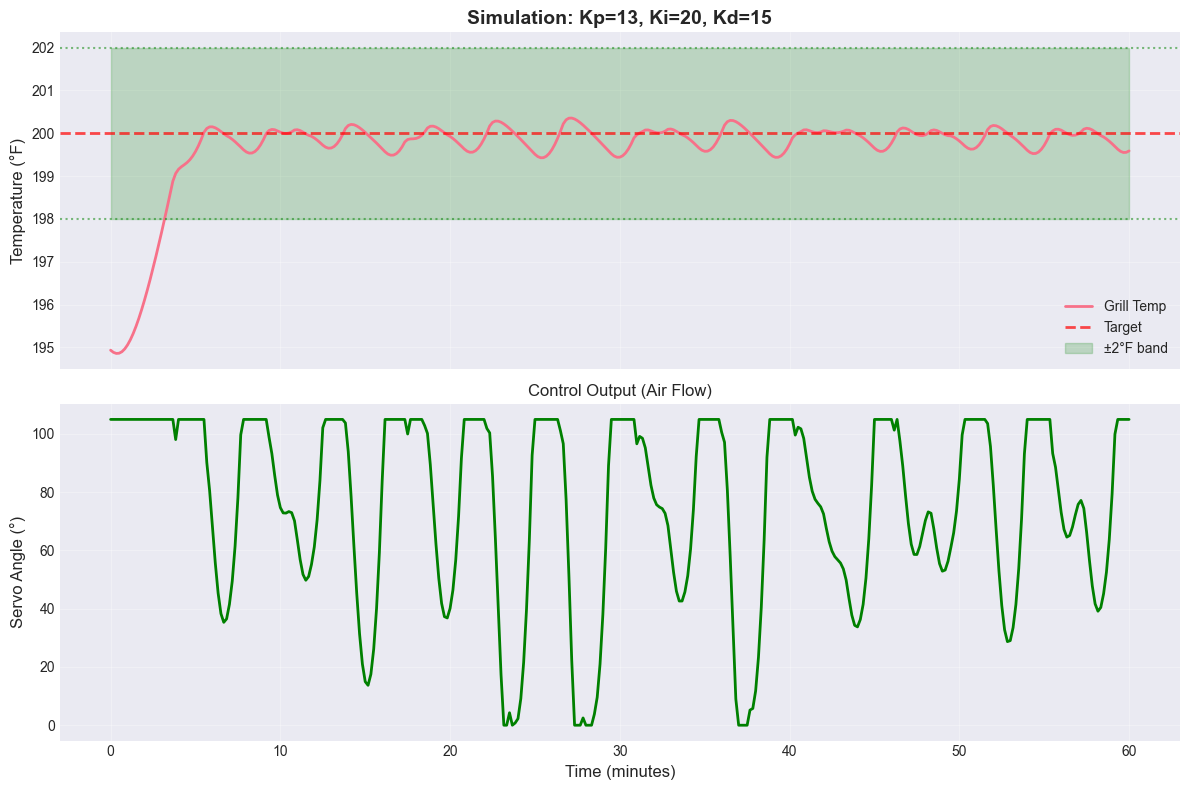


=== Performance Metrics ===
Max Overshoot:  0.35°F
Max Undershoot: -5.14°F
Settling Time:  3.3 min
Mean Abs Error: 0.43°F
RMSE:           1.04°F


In [85]:
# Compare current vs optimized
print("\n" + "="*50)
print("CURRENT PID PARAMETERS (Kp=13, Ki=20, Kd=15)")
print("Steady-state test: 195°F → 200°F")
print("="*50)
current_results = simulate_grill_control(13, 20, 15, initial_temp=195, duration=3600)


OPTIMIZED PID PARAMETERS (Kp=27.99, Ki=34.63, Kd=20.04)
Steady-state test: 195°F → 200°F


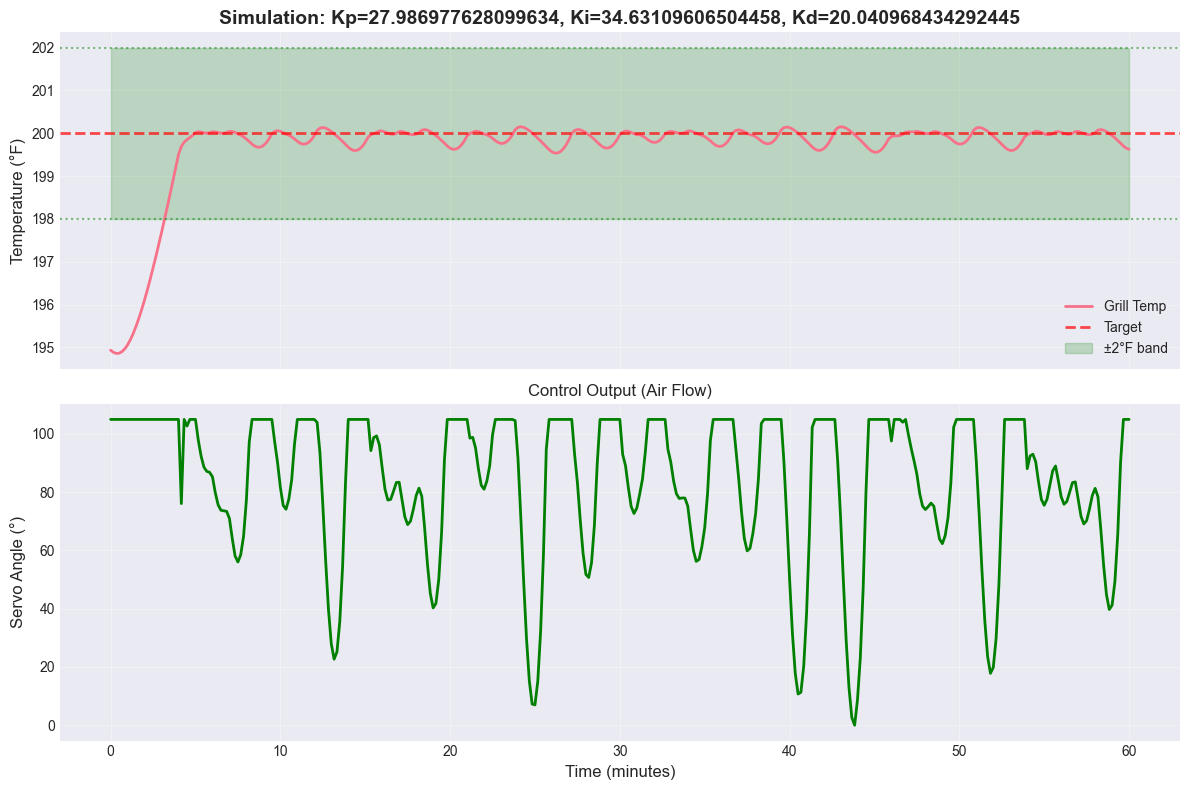


=== Performance Metrics ===
Max Overshoot:  0.15°F
Max Undershoot: -5.14°F
Settling Time:  3.3 min
Mean Abs Error: 0.36°F
RMSE:           1.02°F


In [86]:
print("\n" + "="*50)
print(f"OPTIMIZED PID PARAMETERS (Kp={optimal_kp:.2f}, Ki={optimal_ki:.2f}, Kd={optimal_kd:.2f})")
print("Steady-state test: 195°F → 200°F")
print("="*50)
optimal_results = simulate_grill_control(optimal_kp, optimal_ki, optimal_kd, initial_temp=195, duration=3600)

## 9. Batch Testing - Test Multiple PID Combinations

Quickly test a grid of PID parameters.

Testing 80 combinations...

Top 10 PID combinations:
 kp  ki  kd      cost
 20  30  20 13.619423
 30  30  20 13.850185
 30  30  15 13.850212
 30  30  10 13.850240
 30  30   5 13.850267
 20  30  15 13.885232
 20  30  10 13.885738
 20  30   5 13.942920
 30  15   5 13.997911
 30  15  20 14.003326


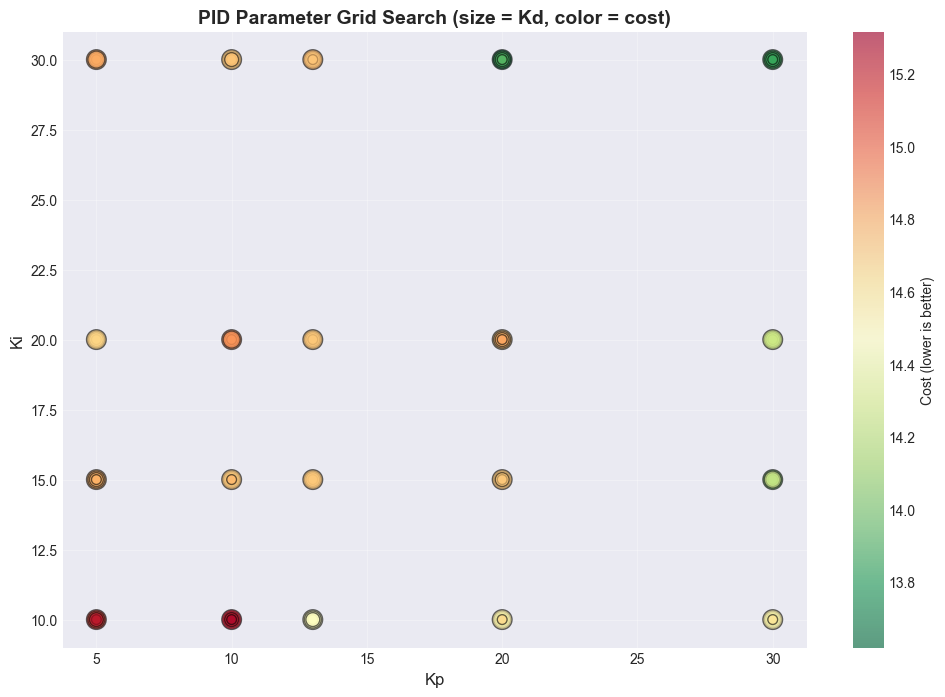

In [87]:
# Test a grid of parameters
kp_values = [5, 10, 13, 20, 30]
ki_values = [10, 15, 20, 30]
kd_values = [5, 10, 15, 20]

results_grid = []

print(f"Testing {len(kp_values) * len(ki_values) * len(kd_values)} combinations...")

for kp in kp_values:
    for ki in ki_values:
        for kd in kd_values:
            cost = objective_function([kp, ki, kd], duration=1800)  # 30 min sim
            results_grid.append({
                'kp': kp,
                'ki': ki,
                'kd': kd,
                'cost': cost
            })

# Convert to DataFrame and sort
grid_df = pd.DataFrame(results_grid)
grid_df = grid_df.sort_values('cost')

print("\nTop 10 PID combinations:")
print(grid_df.head(10).to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(grid_df['kp'], grid_df['ki'], 
                    c=grid_df['cost'], s=grid_df['kd']*10,
                    cmap='RdYlGn_r', alpha=0.6, edgecolors='black')
ax.set_xlabel('Kp', fontsize=12)
ax.set_ylabel('Ki', fontsize=12)
ax.set_title('PID Parameter Grid Search (size = Kd, color = cost)', 
            fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cost (lower is better)')
plt.grid(True, alpha=0.3)
plt.show()

## 10. Export Optimal Parameters

Generate code snippets to update your Arduino code.

In [73]:
print("\n" + "="*60)
print("COPY THIS TO YOUR ARDUINO CODE")
print("="*60)
print(f"\ndouble pidP = {optimal_kp:.2f};")
print(f"double pidI = {optimal_ki:.2f};")
print(f"double pidD = {optimal_kd:.2f};")
print("\n" + "="*60)

print("\n" + "="*60)
print("OR USE THESE CURL COMMANDS TO UPDATE RUNNING CONTROLLER")
print("="*60)
print(f'\ncurl -X POST -H "Content-Type: text/plain" "http://10.0.0.10/setpidp" -d "{optimal_kp:.2f}"')
print(f'curl -X POST -H "Content-Type: text/plain" "http://10.0.0.10/setpidi" -d "{optimal_ki:.2f}"')
print(f'curl -X POST -H "Content-Type: text/plain" "http://10.0.0.10/setpidd" -d "{optimal_kd:.2f}"')
print("\n" + "="*60)


COPY THIS TO YOUR ARDUINO CODE

double pidP = 6.41;
double pidI = 31.74;
double pidD = 0.39;


OR USE THESE CURL COMMANDS TO UPDATE RUNNING CONTROLLER

curl -X POST -H "Content-Type: text/plain" "http://10.0.0.10/setpidp" -d "6.41"
curl -X POST -H "Content-Type: text/plain" "http://10.0.0.10/setpidi" -d "31.74"
curl -X POST -H "Content-Type: text/plain" "http://10.0.0.10/setpidd" -d "0.39"



## 11. Save Results

In [74]:
# Save results to CSV
output_file = 'pid_optimization_results.csv'
grid_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Save optimal parameters
with open('optimal_pid.txt', 'w') as f:
    f.write(f"Optimal PID Parameters\n")
    f.write(f"=====================\n")
    f.write(f"Kp = {optimal_kp:.2f}\n")
    f.write(f"Ki = {optimal_ki:.2f}\n")
    f.write(f"Kd = {optimal_kd:.2f}\n")
    f.write(f"\nCost: {result.fun:.2f}\n")
print("Optimal parameters saved to optimal_pid.txt")

Results saved to pid_optimization_results.csv
Optimal parameters saved to optimal_pid.txt
